In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# garantir acesso ao projeto
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("."))

# Carregar base para visualizações
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Configurações estéticas
sns.set(style="whitegrid", context="talk", palette="deep")

# Carregar distribuições de acurácia geradas no notebook 05
# (vamos salvar no final do notebook 05 — já deixo pronto aqui)
import pickle

with open("../models/acc_results.pkl", "rb") as f:
    resultados = pickle.load(f)

acc_rf_o   = resultados["acc_rf_o"]
acc_rf_pca = resultados["acc_rf_pca"]
acc_rf_ae  = resultados["acc_rf_ae"]
acc_svm_o   = resultados["acc_svm_o"]
acc_svm_pca = resultados["acc_svm_pca"]
acc_svm_ae  = resultados["acc_svm_ae"]

# Carregar encoder do AE
with open("../models/encoder.pkl", "rb") as f:
    encoder = pickle.load(f)

print("Dados carregados com sucesso!")




Dados carregados com sucesso!


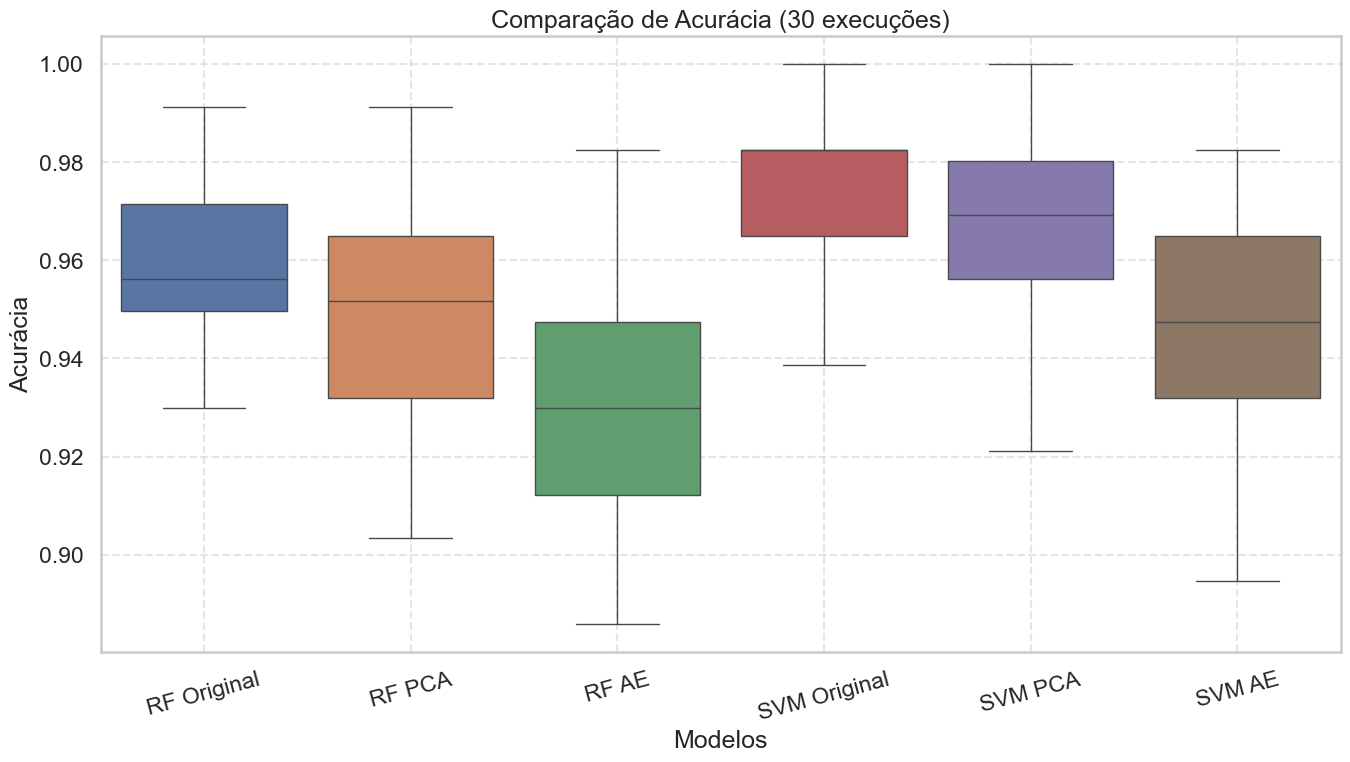

In [3]:
plt.figure(figsize=(16, 8))

dados_box = [
    acc_rf_o, acc_rf_pca, acc_rf_ae,
    acc_svm_o, acc_svm_pca, acc_svm_ae
]

labels = [
    "RF Original", "RF PCA", "RF AE",
    "SVM Original", "SVM PCA", "SVM AE"
]

sns.boxplot(data=dados_box)
plt.xticks(ticks=range(6), labels=labels, rotation=15)
plt.title("Comparação de Acurácia (30 execuções)")
plt.ylabel("Acurácia")
plt.xlabel("Modelos")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


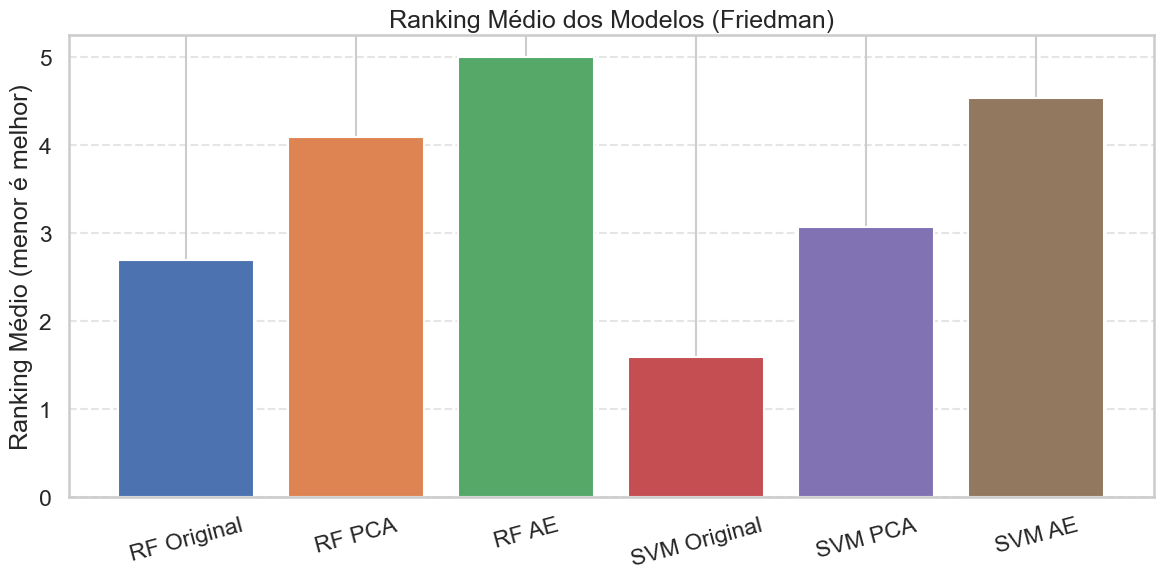

Ranking médio dos modelos: [2.7        4.1        5.         1.6        3.06666667 4.53333333]


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Matriz: cada coluna = modelo, cada linha = acurácia da execução i
matriz_execucoes = np.vstack([
    acc_rf_o,
    acc_rf_pca,
    acc_rf_ae,
    acc_svm_o,
    acc_svm_pca,
    acc_svm_ae
]).T  # shape (30 execuções, 6 modelos)

# calcular o ranking por linha
rankings = np.argsort(np.argsort(-matriz_execucoes, axis=1), axis=1) + 1
ranking_medio = rankings.mean(axis=0)

labels = [
    "RF Original", "RF PCA", "RF AE",
    "SVM Original", "SVM PCA", "SVM AE"
]

plt.figure(figsize=(14, 6))
plt.bar(labels, ranking_medio, color=sns.color_palette("deep"))
plt.title("Ranking Médio dos Modelos (Friedman)")
plt.ylabel("Ranking Médio (menor é melhor)")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

print("Ranking médio dos modelos:", ranking_medio)


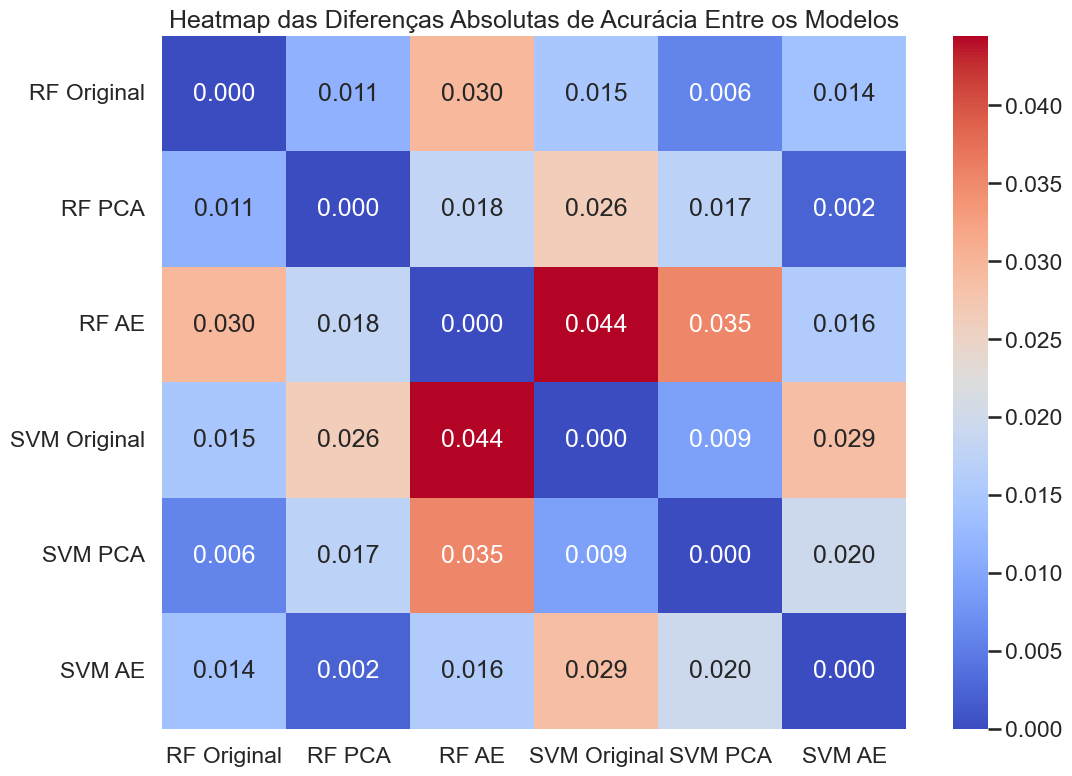

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Médias dos 6 modelos
medias = np.array([
    acc_rf_o.mean(),
    acc_rf_pca.mean(),
    acc_rf_ae.mean(),
    acc_svm_o.mean(),
    acc_svm_pca.mean(),
    acc_svm_ae.mean()
])

labels = [
    "RF Original", "RF PCA", "RF AE",
    "SVM Original", "SVM PCA", "SVM AE"
]

# Matriz de diferenças absolutas
diff_matrix = np.abs(medias.reshape(-1, 1) - medias.reshape(1, -1))

plt.figure(figsize=(12, 9))
sns.heatmap(
    diff_matrix,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    xticklabels=labels,
    yticklabels=labels
)
plt.title("Heatmap das Diferenças Absolutas de Acurácia Entre os Modelos")
plt.show()


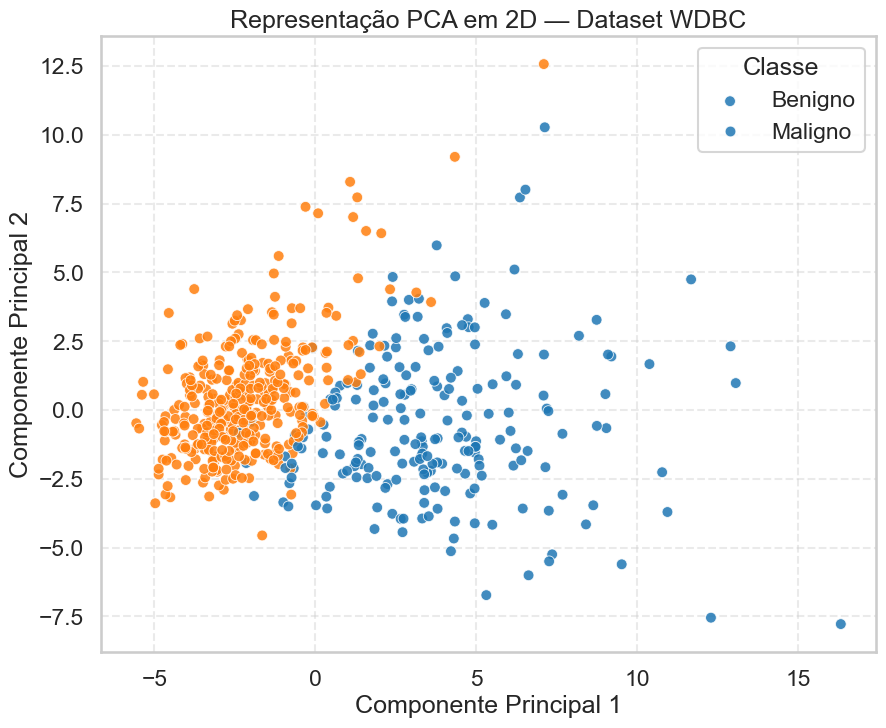

In [6]:
# Carregar base
data = load_breast_cancer()
X = data.data
y = data.target

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 2D
pca_2d = PCA(n_components=2)
Z_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=Z_pca_2d[:, 0],
    y=Z_pca_2d[:, 1],
    hue=y,
    palette=["#1f77b4", "#ff7f0e"],
    s=60,
    alpha=0.85
)
plt.title("Representação PCA em 2D — Dataset WDBC")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Classe", labels=["Benigno", "Maligno"])
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


18/18 [==============================] - 0s 5ms/step


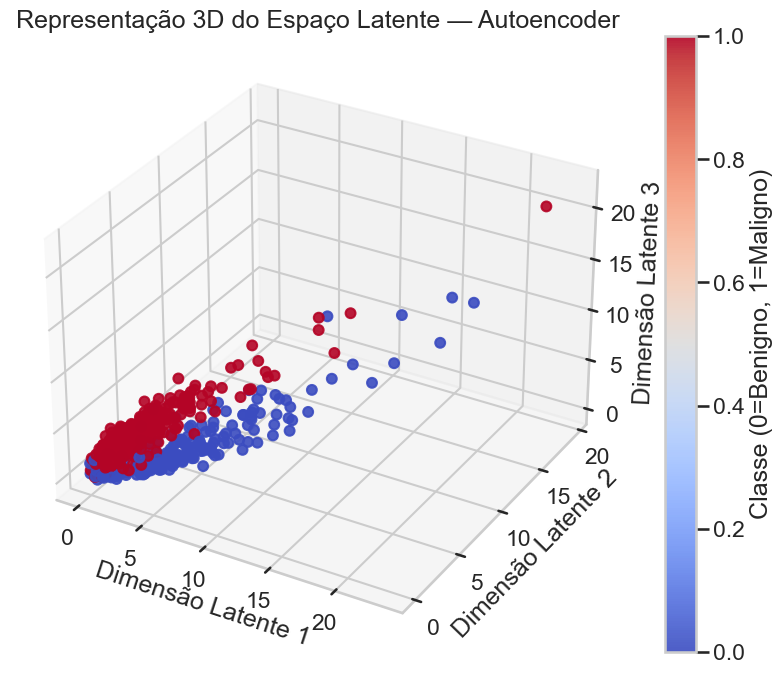

In [7]:
from mpl_toolkits.mplot3d import Axes3D

# Aplicar encoder aos dados completos
Z_ae = encoder.predict(X_scaled)   # X_scaled veio do PCA 2D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    Z_ae[:, 0], Z_ae[:, 1], Z_ae[:, 2],
    c=y,
    cmap="coolwarm",
    s=50,
    alpha=0.9
)

ax.set_title("Representação 3D do Espaço Latente — Autoencoder")
ax.set_xlabel("Dimensão Latente 1")
ax.set_ylabel("Dimensão Latente 2")
ax.set_zlabel("Dimensão Latente 3")

plt.colorbar(sc, label="Classe (0=Benigno, 1=Maligno)")
plt.show()


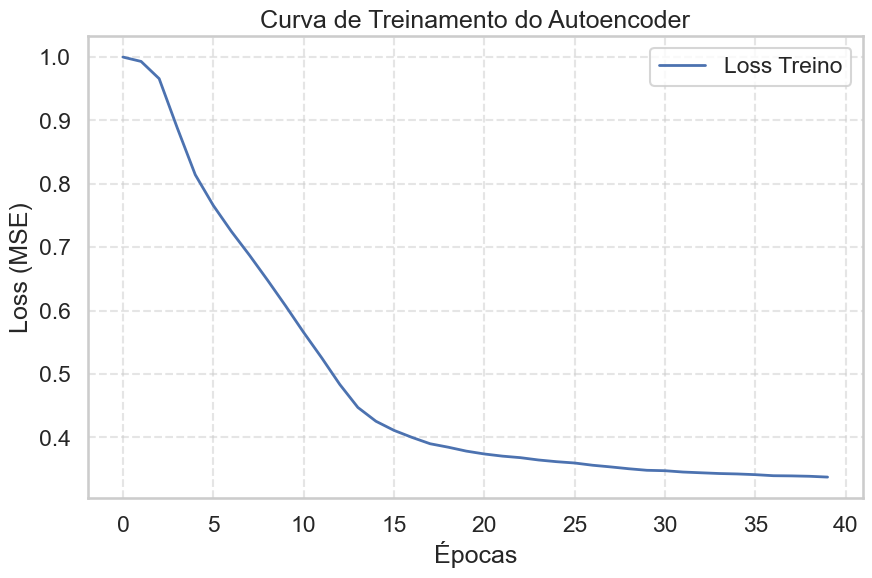

In [8]:
# Carregar history
with open("../models/ae_history.pkl", "rb") as f:
    ae_history = pickle.load(f)

plt.figure(figsize=(10, 6))

plt.plot(ae_history["loss"], label="Loss Treino", linewidth=2)

# Caso exista validação no history
if "val_loss" in ae_history:
    plt.plot(ae_history["val_loss"], label="Loss Validação", linewidth=2)

plt.title("Curva de Treinamento do Autoencoder")
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


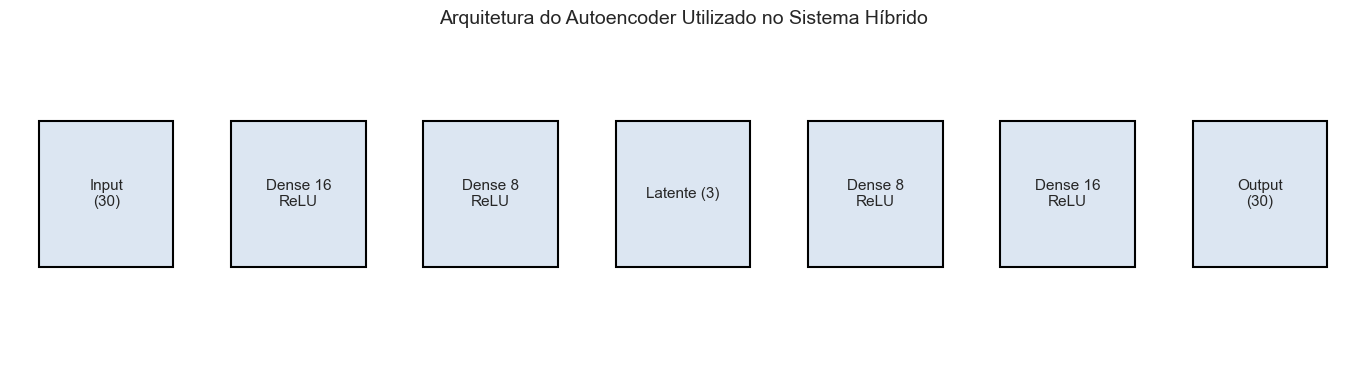

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def draw_layer(ax, center, width, height, label):
    x = center[0] - width/2
    y = center[1] - height/2
    rect = Rectangle((x, y), width, height,
                     fill=True, edgecolor='black',
                     facecolor='#dce6f2', linewidth=1.5)
    ax.add_patch(rect)
    ax.text(center[0], center[1], label,
            ha='center', va='center', fontsize=11)

plt.figure(figsize=(14, 4))
ax = plt.gca()
ax.axis('off')

# Coordenadas centrais para melhorar alinhamento
centers = [
    (1, 1),   # Input
    (3, 1),   # Dense 16
    (5, 1),   # Dense 8
    (7, 1),   # Latent
    (9, 1),   # Dense 8
    (11, 1),  # Dense 16
    (13, 1),  # Output
]

labels = [
    "Input\n(30)",
    "Dense 16\nReLU",
    "Dense 8\nReLU",
    "Latente (3)",
    "Dense 8\nReLU",
    "Dense 16\nReLU",
    "Output\n(30)"
]

# Desenhar as camadas
for c, label in zip(centers, labels):
    draw_layer(ax, c, width=1.4, height=0.9, label=label)

# Setas entre as camadas
for i in range(len(centers) - 1):
    x1, y1 = centers[i]
    x2, y2 = centers[i+1]
    ax.annotate("",
                xy=(x2 - 0.9, y2),
                xytext=(x1 + 0.9, y1),
                arrowprops=dict(arrowstyle="->", lw=2))

plt.xlim(0, 14)
plt.ylim(0, 2)

plt.title("Arquitetura do Autoencoder Utilizado no Sistema Híbrido", fontsize=14)
plt.tight_layout()
plt.show()
